# <a>Project - Recommendation Systems</a>
## <a>Product Recommendation based on Amazon reviews data <a>
by Sandesh Balyan

<div class="list-group" id="list-tab" role="tablist">
  <h3 class="list-group-item list-group-item-action active" data-toggle="list"  role="tab" aria-controls="home">Table of Contents</h3>
  <a class="list-group-item list-group-item-action" data-toggle="list" href="#eda" role="tab" aria-controls="profile">1. Exploratory Data Analysis and Preprocessing<span class="badge badge-primary badge-pill">1</span></a>
    <a class="list-group-item list-group-item-action" data-toggle="list" href="#2" role="tab" aria-controls="profile">2. Handling sparsity in dataset<span class="badge badge-primary badge-pill">2</span></a>
    <a class="list-group-item list-group-item-action" data-toggle="list" href="#3" role="tab" aria-controls="profile">3. Popularity based recommender system<span class="badge badge-primary badge-pill">3</span></a>
    <a class="list-group-item list-group-item-action" data-toggle="list" href="#4" role="tab" aria-controls="profile">4. Splitting the dataset<span class="badge badge-primary badge-pill">4</span></a>
    <a class="list-group-item list-group-item-action" data-toggle="list" href="#5" role="tab" aria-controls="profile">5. Collaborative filtering based recommender system<span class="badge badge-primary badge-pill">5</span></a>
    <a class="list-group-item list-group-item-action" data-toggle="list" href="#6" role="tab" aria-controls="profile">6. Model Evaluation and hyperparameter tuning<span class="badge badge-primary badge-pill">6</span></a>
    <a class="list-group-item list-group-item-action" data-toggle="list" href="#7" role="tab" aria-controls="profile">7. Predictions based on best model<span class="badge badge-primary badge-pill">7</span></a>
    <a class="list-group-item list-group-item-action" data-toggle="list" href="#8" role="tab" aria-controls="profile">8. Conclusion<span class="badge badge-primary badge-pill">8</span></a>
</div>

# <a>Description <a>
    
    This dataset contains reviews on Amazon's website for elctronic products. Database contains only 4 columns viz a viz 'user'. 'product', 'ratings' and 'timestamp.
    Product Recommendations is essential part of any ecommerce platform and help boost revenue by recommending products based on users interest and need.

# <a>Objective <a>
    To make a recommendation system that recommends at least five(5) new products based on the user's habits
    
    Learning Outcomes -
1. Exploratory Data Analysis
2. Data Wrangling
3. Build a Popularity recommender model
4. Build Collaborative Filtering model

# <a id='eda'>1. Exploratory Data Analysis and Preprocessing <a>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import surprise as sp
from surprise import KNNWithMeans
import warnings
warnings.filterwarnings('ignore')
import itertools
import time
from scipy.sparse import csr_matrix

In [2]:
data = pd.read_csv('ratings_Electronics.csv',header=None,names=['userid','productid','rating','timestamp'])
data.head()

,userid,productid,rating,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


In [3]:
data.shape

(7824482, 4)

In [4]:
data.isna().count()

userid       7824482
productid    7824482
rating       7824482
timestamp    7824482
dtype: int64

In [5]:
data.duplicated().value_counts()

False    7824482
dtype: int64

In [6]:
#Drop column timestamp
data = data.drop('timestamp',axis=1)

##### Insights:
1. There are 7.8 million observations in the dataset and 4 Variables
2. Variable timestamp shall be dropped
3. There are no duplicate observations in the dataset

## 1.1 Descriptive Statistics

In [7]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
rating,7824482.0,4.012337,1.38091,1.0,3.0,5.0,5.0,5.0


##### Insights:

Since there is only one numeric column 'rating' hence we have only one row in the describe data

1. Total number of records in this dataset are 7.8 million
2. minimum rating is 1 and maximum rating is 5
3. mean rating is approx. 4 but median rating is 5
4. Data seems to be a little right taled with most more than 50% values being 5.0

In [8]:
print('Total number of unique Users in the dataset are {}'.format(data['userid'].nunique()))
print('Total number of unique Products in the dataset are {}'.format(data['productid'].nunique()))

Total number of unique Users in the dataset are 4201696
Total number of unique Products in the dataset are 476002


## 1.2 Distribution of ratings over users

### 1.2.1 Bucketing user wise ratings

In this section we will bucket ratings into bins and analyse them using barplot. This plot will help us get the idea of which bin has most of the rating and hence helping in tacklin sparsity of the data in next sections

In [9]:
data.groupby(by='userid',axis=0).agg({'rating':'count'}).sort_values(by='rating',ascending=False).index

Index(['A5JLAU2ARJ0BO', 'ADLVFFE4VBT8', 'A3OXHLG6DIBRW8', 'A6FIAB28IS79',
       'A680RUE1FDO8B', 'A1ODOGXEYECQQ8', 'A36K2N527TXXJN', 'A2AY4YUOX2N1BQ',
       'AWPODHOB4GFWL', 'A25C2M3QF9G7OQ',
       ...
       'A2HRAW9HMZHIDT', 'A2HRAXHLYHEQWQ', 'A2HRAYKYS0GUWM', 'A2HRB7LG0EQ71B',
       'A2HRB87C2M7MDV', 'A2HRB8UOXH92SQ', 'A2HRBA4HO2E4GU', 'A2HRBCM00IDK56',
       'A2HRBEBDTIB8MT', 'AZZZY1W55XHZR'],
      dtype='object', name='userid', length=4201696)

In [10]:
# Divide data into bins of 50 starting from 0  to 550
df1= data.groupby(by='userid',axis=0).agg({'rating':'count'}).sort_values(by='rating',ascending=False)
#df1[df1['rating']>50]
bins = [0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550]
df1['bins'] = pd.cut(df1['rating'],bins)
df1

,rating,bins
userid,,
A5JLAU2ARJ0BO,520,"(500, 550]"
ADLVFFE4VBT8,501,"(500, 550]"
A3OXHLG6DIBRW8,498,"(450, 500]"
A6FIAB28IS79,431,"(400, 450]"
A680RUE1FDO8B,406,"(400, 450]"
...,...,...
A2HRB8UOXH92SQ,1,"(0, 50]"
A2HRBA4HO2E4GU,1,"(0, 50]"
A2HRBCM00IDK56,1,"(0, 50]"


In [11]:
df1.columns


Index(['rating', 'bins'], dtype='object')

We can see that userid has become the index and there are only 2 columns ratings and bins

In [12]:
df1['bins'].value_counts()

(0, 50]       4200230
(50, 100]        1186
(100, 150]        182
(150, 200]         47
(200, 250]         28
(250, 300]         14
(300, 350]          3
(500, 550]          2
(400, 450]          2
(450, 500]          1
(350, 400]          1
Name: bins, dtype: int64

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 <a list of 11 Text major ticklabel objects>)

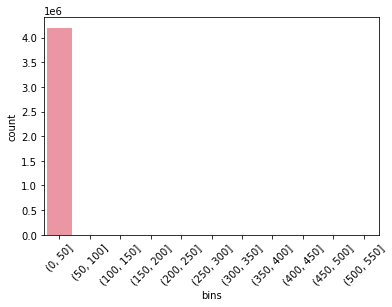

In [13]:
sns.countplot(df1['bins'])
plt.xticks(rotation=45)

In [14]:
print('Number of users who have given less than 50 ratings are : {0} --> approx : {1:.2f} %'.format(df1['bins'].value_counts()[0],(df1['bins'].value_counts()[0]/data['userid'].nunique())*100))
print('Number of users who have given more than 50 ratings are : {0} --> approx : {1:.2f} %'.format(data['userid'].nunique() - df1['bins'].value_counts()[0],((data['userid'].nunique() - df1['bins'].value_counts()[0])/data['userid'].nunique())*100))

Number of users who have given less than 50 ratings are : 4200230 --> approx : 99.97 %
Number of users who have given more than 50 ratings are : 1466 --> approx : 0.03 %


##### Insights:
1. We can see from barplot as well as the value counts that only 0.03% users have rated more than 50 products, which is very small. 
2. We need to check the data in first bin 0-50

In [15]:
df1['bins'] = df1['bins'].apply(lambda x: str(x))
df11 = df1[df1['bins'] == '(0, 50]']
bins = np.arange(0,51,5)
df11['bins2'] = pd.cut(df11['rating'],bins)
df11['bins2'].value_counts()

(0, 5]      4023027
(5, 10]      127256
(10, 15]      29019
(15, 20]      10383
(20, 25]       4688
(25, 30]       2468
(30, 35]       1505
(35, 40]        831
(40, 45]        612
(45, 50]        441
Name: bins2, dtype: int64

#####  Insights:
By further drilling down we can see that about 4 million users have rated less than 5 products which is a little more than 95% of total number of users (4201696). This is crucial we will check this in the later sections

### 1.2.2 Bucketing Product wise ratings

In [16]:
df2 = data.groupby(by='productid',axis=0).agg({'rating':'count'}).sort_values(by='rating',ascending=False)
bins = np.arange(0,20000,1000)
df2['bins'] = pd.cut(df2['rating'],bins)
df2


,rating,bins
productid,,
B0074BW614,18244,"(18000, 19000]"
B00DR0PDNE,16454,"(16000, 17000]"
B007WTAJTO,14172,"(14000, 15000]"
B0019EHU8G,12285,"(12000, 13000]"
B006GWO5WK,12226,"(12000, 13000]"
...,...,...
B004WL91KI,1,"(0, 1000]"
B004WL9FK4,1,"(0, 1000]"
B004WL9Q2Q,1,"(0, 1000]"


In [17]:
df2['bins'] = df2['bins'].apply(lambda x: str(x))

In [18]:
df2['bins'].value_counts()

(0, 1000]         475337
(1000, 2000]         479
(2000, 3000]          99
(3000, 4000]          35
(4000, 5000]          25
(5000, 6000]           5
(6000, 7000]           5
(8000, 9000]           4
(7000, 8000]           3
(9000, 10000]          3
(12000, 13000]         2
(10000, 11000]         1
(11000, 12000]         1
(14000, 15000]         1
(16000, 17000]         1
(18000, 19000]         1
(17000, 18000]         0
(13000, 14000]         0
(15000, 16000]         0
Name: bins, dtype: int64

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18]),
 <a list of 19 Text major ticklabel objects>)

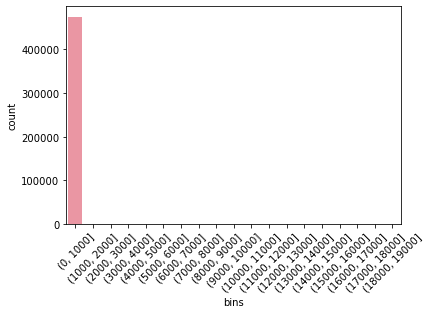

In [19]:
sns.countplot(df2['bins'])
plt.xticks(rotation=45)

In [20]:
print('Number of Products who have received less than 1000 ratings are : {0} --> approx : {1:.2f} %'.format(df2['bins'].value_counts()[0],(df2['bins'].value_counts()[0]/data['productid'].nunique())*100))
print('Number of Products who have received more than 1000 ratings are : {0} --> approx : {1:.2f} %'.format(data['productid'].nunique() - df2['bins'].value_counts()[0],((data['productid'].nunique() - df2['bins'].value_counts()[0])/data['productid'].nunique())*100))

Number of Products who have received less than 1000 ratings are : 475337 --> approx : 99.86 %
Number of Products who have received more than 1000 ratings are : 665 --> approx : 0.14 %


##### Insights:
1. There are Total 476,002 unique products
2. Out of these 99.86% i.e. 475,337 have received less thn 1000 ratings while 0.14% have received more than 1000 ratings. This will help us in deciding sparsity in further sections. We may have to further drill down into products with less than 1000 ratings.|

### Check further division of items less than 1000 ratings

In [21]:
bins = np.arange(0,1001,100)
df21=df2[df2['bins'] == '(0, 1000]']
df21['bins2'] = pd.cut(df21['rating'],bins)
df21['bins2'].value_counts()

(0, 100]       462925
(100, 200]       6992
(200, 300]       2359
(300, 400]       1190
(400, 500]        666
(500, 600]        443
(600, 700]        277
(700, 800]        209
(800, 900]        153
(900, 1000]       123
Name: bins2, dtype: int64

##### Insights:
It is clear that around 97% (462,925) products have received less than 100 ratings. Only 3% products have received more than 100 ratings

## 1.3 Distribution of column 'Ratings'

### 1.3.1 Overall distribution of ratings across dataset

In [22]:
df_rating = data.groupby(by='rating').agg({'userid':'count'})
df_rating.reset_index(level=0,inplace=True)
df_rating.rename(columns={'userid':'counts'},inplace=True)
df_rating

,rating,counts
0,1.0,901765
1,2.0,456322
2,3.0,633073
3,4.0,1485781
4,5.0,4347541


Text(0.5, 1.0, 'Distribution of ratings')

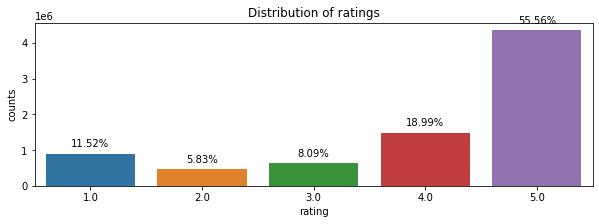

In [23]:
fig1,ax = plt.subplots(1,1,figsize=(10,3))
splot = sns.barplot(x='rating',y='counts',data=df_rating,ax=ax)

for p in splot.patches:
    splot.annotate(format(p.get_height()/len(data)*100, '.2f') + '%', (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

plt.title('Distribution of ratings')

##### Insights:
1. Out of all the ratings in the dataset staggering 55.56% are 5.0 which means 55.56% combinations of user and products have rating 5
2. Most of the combinations have rating 3 or higher and only 18% of total entries have ratings 1 and 2
3. This is quite an imbalanced dataset interms of ratings

### 1.3.1 Distribution of users and products with ratings

Text(0.5, 1.0, 'Distribution of users with ratings')

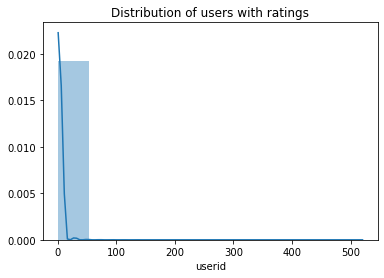

In [24]:
sns.distplot(data['userid'].value_counts(),bins=10)
plt.title('Distribution of users with ratings')


##### Insights:
1. Above plot represents distribution of users with ratings i.e how many users have given how many ratings
2. We can see that distribution is right tailed and most of the users have given ratings for less than 50 products
3. cummulatively there are very less number of users who have rated more than 50 products

Text(0.5, 1.0, 'Distribution of products with ratings')

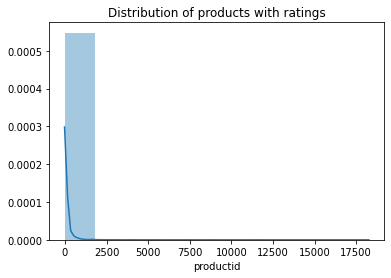

In [25]:
sns.distplot(data['productid'].value_counts(),bins=10)
plt.title('Distribution of products with ratings')


##### Insights:
1. Above plot represents distribution of products with ratings i.e how many products have received how many ratings
2. Distribution is right tailed and maximum number of products have received less than 2500 ratings
3. products who have received ratings more than 2500 are very less in number cummulatively

# <a id='2'>2. Handling Sparsity in Dataset<a>
    
    In this section we will extract only those users who have rated more than and equal to 50 products. We have seen in the above sections that there are only 1540 users who have done so.
    
#### Note: In instrucitons it has been asked to select a subset of dataset to make the dataset more denser. Its also suggested as an example to select number of users who have  rated atleast 50 products. However, in my opinion since we need to create Popularity based recommender system, we should choose products which have received more than 50 ratings to judge their popularity and not the users who have rated more than 50 products. Hence I have selected here 'Products which have recieved more than 50 ratings'

### 2.1 Selecting a subset  - Users who have rated more than 50 products

In [26]:
df_top_users = data.groupby(by='userid').agg({'rating':'count'}).sort_values(by='rating',ascending=False)
df_top_users = df_top_users[df_top_users['rating']>=50]
df_users = data[data['userid'].isin(list(df_top_users.index))].sort_values(by=['userid','productid'])
df_users

,userid,productid,rating
66537,A100UD67AHFODS,B00004Z5M1,5.0
123861,A100UD67AHFODS,B00005T3X7,5.0
165910,A100UD67AHFODS,B000069EUW,5.0
166702,A100UD67AHFODS,B000069JWX,1.0
322741,A100UD67AHFODS,B0000AR0I4,5.0
...,...,...,...
6859295,AZOK5STV85FBJ,B00AANMVNQ,5.0
7005691,AZOK5STV85FBJ,B00B25P27S,4.0
7087060,AZOK5STV85FBJ,B00BF6HVG4,5.0
7619713,AZOK5STV85FBJ,B00FB2XNCE,5.0


### 2.2 Selecting a subset - Products which have received more than 50 ratings

1. We will create a dataframe by grouping by productid and and count of ratings.
2. From this dataframe we will choose index od products with count  >=50.
3. We will then create a separate dataframe with values from these indices in step2

In [27]:
df_top_products = data.groupby(by='productid').agg({'rating':'count'}).sort_values(by='rating',ascending=False)
df_top_products = df_top_products[df_top_products['rating']>=50]
df_items = data[data['productid'].isin(list(df_top_products.index))].sort_values(by=['userid','productid'])
df_items

,userid,productid,rating
3588866,A00000262KYZUE4J55XGL,B003UYU16G,5.0
4120406,A00009661LC9LQPGKJ24G,B004GWQBWY,5.0
2837258,A00010809P09NUU6ZP6H,B002SSM5AU,5.0
7596618,A000145014WOTZJ5NSKOR,B00F3L19KQ,5.0
2150997,A00015222LZ55IJSVL5IX,B001MSVPM6,1.0
...,...,...,...
1906753,AZZZRS1YZ8HVP,B001CJOLBW,4.0
7440046,AZZZRS1YZ8HVP,B00DR0PDNE,4.0
6608010,AZZZSIK7NFFVP,B009FU8BR0,5.0
1749662,AZZZWXXUPZ1F3,B0016CFZQ0,5.0


In [28]:
print('Number of unique products withmore than 50 ratings: {0}'.format(df_items['productid'].nunique()))


Number of unique products withmore than 50 ratings: 26226


### 2.3 Sparsity comparison

Since now we have already selected users and products for those products who have recieved more than 50 ratings. 
Lets compare the original dataframe with this dataframe to check the sparsity and how much increase in density have we managed

#### # Density of original data

In [29]:
df_sparse = data.copy()
df_sparse['userid'] = df_sparse['userid'].astype('category')
df_sparse['productid'] = df_sparse['productid'].astype('category')
rows = df_sparse['userid'].cat.codes
cols = df_sparse['productid'].cat.codes
rating = df_sparse['rating']
mat_ratings = csr_matrix((rating, (rows, cols)))
mat_ratings.eliminate_zeros()

#density calculations
sparse_density = mat_ratings.getnnz()/(mat_ratings.shape[0]*mat_ratings.shape[1])
print('Density of the original data: {0}'.format(sparse_density))

Density of the original data: 3.912210290338533e-06


#### # Density after selecting products with more than 50 ratings

In [30]:
# compare here sparsity of the 2 dataframes
df_sparse1 = df_items.copy()
df_sparse1['userid'] = df_sparse1['userid'].astype('category')
df_sparse1['productid'] = df_sparse1['productid'].astype('category')
rows = df_sparse1['userid'].cat.codes
cols = df_sparse1['productid'].cat.codes
rating = df_sparse1['rating']
mat_ratings_1 = csr_matrix((rating, (rows, cols)))
mat_ratings_1.eliminate_zeros()

#density calculations
sparse_density1 = mat_ratings_1.getnnz()/(mat_ratings_1.shape[0]*mat_ratings_1.shape[1])
print('density after selecting products with more than 50 ratings: {0}'.format(sparse_density1))



density after selecting products with more than 50 ratings: 6.353765044727139e-05


In [31]:
increase = ((sparse_density1 - sparse_density)/sparse_density1)*100
print('Percentage increase in density of the data : {0:.2f} %'.format(increase))

Percentage increase in density of the data : 93.84 %


##### Insights:
1. There are total 5,374,313 observations for products which are given more than 50 ratings
2. Total unique products in this list are: 26,226
3. When products with more than 50 ratings has been selected, dataframe has become denser by 93%
4. We will use this dataset 'df_items' to build Popularity based recommendation systems

# <a id = '3'> 3. Popularity Based Recommender System <a>


1. Our Target is to predict most popular items 
2. We also need to take care that the user has not already bought and rated that item
3. all the users will be predicted the same products which are popular, except for those items which have already been bought and rated by that user

## 3.1 Preparing the dataset

In [32]:
df_prod = df_items.groupby(by='productid',axis=0).agg({'userid':'count','rating':'mean'}).sort_values(by='userid',ascending=False)
df_prod.reset_index(level=0,inplace=True)
df_prod.rename(columns={'userid':'rating_count','rating':'mean_rating'},inplace=True)
df_prod

,productid,rating_count,mean_rating
0,B0074BW614,18244,4.491504
1,B00DR0PDNE,16454,3.931020
2,B007WTAJTO,14172,4.424005
3,B0019EHU8G,12285,4.754497
4,B006GWO5WK,12226,4.314657
...,...,...,...
26221,B002653KNQ,50,3.400000
26222,B001W81LZ2,50,3.020000
26223,B0001G6UES,50,4.060000
26224,B008NC8IB0,50,3.540000


##### Insights:
1. Using group by we have a dataframe with single row for each product, NUmber of ratings for that product and mean rating of the product
2. rating count shows that the product is bought very frequently while mean rating demonstrtates weather the product is liked by the user or not

## 3.2 Most popular items by Rating count

In this case we will assume that an item which has more number of ratings is purchased more frequently and hence popular.
Since we have already removed items which have low number of ratings, we can just sort and get top 10 recommendation for all users

In [33]:
popular_items_rating_count = df_prod.sort_values(by='rating_count',ascending=False)
popular_items_rating_count[:10]


,productid,rating_count,mean_rating
0,B0074BW614,18244,4.491504
1,B00DR0PDNE,16454,3.931020
2,B007WTAJTO,14172,4.424005
3,B0019EHU8G,12285,4.754497
4,B006GWO5WK,12226,4.314657
5,B003ELYQGG,11617,4.392528
6,B003ES5ZUU,10276,4.704749
7,B007R5YDYA,9907,4.690926
8,B00622AG6S,9823,4.420136
9,B0002L5R78,9487,4.448614


Text(0.5, 1.0, '10 Most popular item - based on number of ratings')

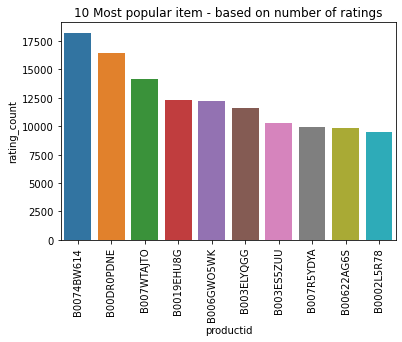

In [34]:
sns.barplot(x='productid',y='rating_count',data=popular_items_rating_count[:10])
plt.xticks(rotation=90)
plt.title('10 Most popular item - based on number of ratings')

## 3.3 Most popular items by Rating (mean rating)

In this case we will assume that an item which has got highest mean rating is most popular. Since we have already removed items which have low number of ratings, we can just sort the dataframe on 'mean rating' and get top 10 recommendations

In [35]:
popular_items_mean_rating = df_prod.sort_values(by='mean_rating',ascending=False)
popular_items_mean_rating[:10]

,productid,rating_count,mean_rating
25757,B002E6R7NG,51,4.980392
21682,B004I763AW,60,4.966667
23376,B003J9QQWU,56,4.964286
14660,B0043ZLFXE,90,4.955556
20620,B000TMFYBO,64,4.953125
6605,B00GMRCAC6,187,4.951872
12777,B008I6RVZU,103,4.951456
4966,B00CG70K78,237,4.949367
17276,B0000DYV9H,76,4.947368
7563,B000053HC5,166,4.945783


Text(0.5, 1.0, '10 Most popular item - based on mean ratings')

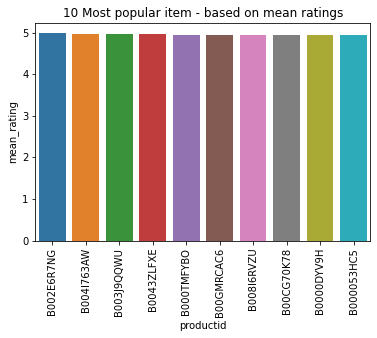

In [36]:
sns.barplot(x='productid',y='mean_rating',data=popular_items_mean_rating[:10])
plt.xticks(rotation=90)
plt.title('10 Most popular item - based on mean ratings')

##### Insights:
1. Difficult to interpret mean rating based sorted items as the mean ratings are very near to each other

## 3.4 User specific recommendations

#### We will recommend top 5 items to each user which they have not already bought or rated so far

In this section we will select top ratings based on number of ratings a product has received for each user and predict only those items which have NOT been bought and rated by the user.

We will make use of complete dataset to get complete list of users and dataframe df_prod to get popularity based items prepared in section 3.1

In this case we will recommend only top 5 items

For the sake of simplicity we will predict products for only 100 users

In [37]:
def reco_popularity(user):
    lst_reco_items = []
    lst_popular_items = list(popular_items_rating_count['productid'])
    existing_items = list(data[data['userid']==user]['productid'])
    for pitem in lst_popular_items:
        if pitem not in existing_items:
            lst_reco_items.append(pitem)
        if len(lst_reco_items) == 5:
            break
    
    return lst_reco_items

In [38]:
# in lst_users we are gathering 100 users for the sake of demonstaration
# Since there are millions of users we will demonstrate this only for 100 users
# this list is of those users who have given maximum number of ratings for products
lst_users = list(data.groupby(by='userid',axis=0).agg({'rating':'count'}).sort_values(by='rating',ascending=False).index)


In [39]:
df_recommendations = pd.DataFrame(columns=['User','Recommendations-Popularity'])

for user in lst_users[:100]:
    df_recommendations.loc[len(df_recommendations)] = [user, reco_popularity(user)]
        

In [40]:
print("Most popular 5 items recommendation for 100 users")
df_recommendations

Most popular 5 items recommendation for 100 users


,User,Recommendations-Popularity
0,A5JLAU2ARJ0BO,"[B0074BW614, B00DR0PDNE, B007WTAJTO, B0019EHU8..."
1,ADLVFFE4VBT8,"[B00DR0PDNE, B007WTAJTO, B003ELYQGG, B007R5YDY..."
2,A3OXHLG6DIBRW8,"[B007WTAJTO, B006GWO5WK, B003ELYQGG, B007R5YDY..."
3,A6FIAB28IS79,"[B007WTAJTO, B0019EHU8G, B006GWO5WK, B003ES5ZU..."
4,A680RUE1FDO8B,"[B0074BW614, B00DR0PDNE, B006GWO5WK, B003ELYQG..."
...,...,...
95,A3W4D8XOGLWUN5,"[B0074BW614, B00DR0PDNE, B0019EHU8G, B006GWO5W..."
96,A17HMM1M7T9PJ1,"[B0074BW614, B00DR0PDNE, B007WTAJTO, B0019EHU8..."
97,A32O5FZH994CNY,"[B0074BW614, B00DR0PDNE, B007WTAJTO, B0019EHU8..."
98,A225G2TFM76GYX,"[B0074BW614, B00DR0PDNE, B007WTAJTO, B0019EHU8..."


### 3.5 Recommendations for single user based on user input

In [41]:
print("Items recommended for users A5JLAU2ARJ0BO are : {}".format(reco_popularity('A5JLAU2ARJ0BO')))

Items recommended for users A5JLAU2ARJ0BO are : ['B0074BW614', 'B00DR0PDNE', 'B007WTAJTO', 'B0019EHU8G', 'B006GWO5WK']


## <a id='4'> 4. Splitting the dataset <a>

    In this case we will use the same dataset df_items with products having ratings more than 50
    

In [42]:
from surprise import KNNWithMeans, SVD
from surprise.model_selection import train_test_split,KFold
from surprise import accuracy
from surprise import Dataset
from surprise import Reader

In [43]:
reader = Reader(rating_scale=(1, 5))
input_data = Dataset.load_from_df(df_items,reader=reader)
trainset, testset = train_test_split(input_data,test_size=0.30)

## <a id='5'>5. Collaborative Filtering based Recommendation System <a>
    
We will use surprise library and KNNwithmens and SVD algorithms.
    
Evaluation will be based on 'Root Mean Square Error (RMSE) and Mean Absolute Error(MAE)
    


## 5.1 Recommendation System using KNNwithmeans()

### 5.1.1 Building algorithm

In [44]:
# Item-item similarity
algo = KNNWithMeans(k=10,sim_options={'name':'pearson_baseline','user_based':False}) 
algo.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


### 5.1.2 Predicting

In [45]:
preds_testset = algo.test(testset)

### 5.1.3 Evaluation
Following function shall build a dataframe for collecting RMS and MAE for each algorithm.

In [46]:
#following function and dataframe shall be used for most 
df_RMSE = pd.DataFrame(columns=['Model','RMSE', 'MAE'])
def rmse_calculation(predictions, model_name):
    rmse = accuracy.rmse(predictions)
    mae = accuracy.mae(predictions)
    print('RMSE - {0}: {1:.4f}'.format(model_name,rmse))
    df_RMSE.loc[len(df_RMSE)] = [model_name,rmse,mae]

In [47]:
rmse_calculation(preds_testset,'KNNwithmeans')

RMSE: 1.3342
MAE:  1.0308
RMSE - KNNwithmeans: 1.3342


### 5.1.4 Cross validate KNN with means

In [48]:
from surprise.model_selection import cross_validate
cv_knnmeans = cross_validate(algo,input_data,cv=5,n_jobs=-1)

In [49]:
cv_knnmeans

{'test_rmse': array([1.33581896, 1.33463139, 1.33527293, 1.33629824, 1.33511195]),
 'test_mae': array([1.02794364, 1.02672284, 1.02761279, 1.02824759, 1.02796629]),
 'fit_time': (400.4766957759857,
  557.949517250061,
  537.922425031662,
  387.4380977153778,
  169.46426510810852),
 'test_time': (157.14521074295044,
  18.656163930892944,
  27.558812856674194,
  29.203767776489258,
  18.222814798355103)}

In [50]:
print('knn with means - mean rmse: {0:.4f}'.format(cv_knnmeans['test_rmse'].mean()))
print('knn with means - mean MAE : {0:.4f}'.format(cv_knnmeans['test_mae'].mean()))

knn with means - mean rmse: 1.3354
knn with means - mean MAE : 1.0277


## 5.2 Recommendation System using SVD()

### 5.2.1 Building Algorithm

In [51]:
algo = SVD()
#svd_cv = cross_validate(algo,input_data,cv=5,n_jobs=-1)
algo.fit(trainset)

### 5.2.2 Predicting

In [52]:
svd_predictions = algo.test(testset)


### 5.2.3 Evaluation

In [53]:
rmse_calculation(svd_predictions, 'SVD')

RMSE: 1.2699
MAE:  0.9944
RMSE - SVD: 1.2699


# <a id='6'>6. Model Evaluation<a>

We wil use RMSE and MAE of the model to evaluate the same

In [54]:
df_RMSE

,Model,RMSE,MAE
0,KNNwithmeans,1.334183,1.030820
1,SVD,1.269892,0.994402


##### Insights
Both RMSE and MAE are lower for SVD. Hence SVD could be the better algorithm for this problem.

## 6.1 Gridsearch CV for chosen algorithm
Since we are clear that SVD has the lowest RMSE and MAE, we shall use gridsearchcv to tune the hyperparameters

In [55]:
from surprise.model_selection import GridSearchCV
hyperparameter = {'n_epochs': [20, 25], 
                  'lr_all': [0.007, 0.009, 0.01],
                  'reg_all': [0.4, 0.6]}


svd_gcv = GridSearchCV(SVD,hyperparameter,cv=5,n_jobs=-1)

svd_gcv.fit(input_data)

In [56]:
print('Best paramters are')
svd_gcv.best_params

Best paramters are


{'rmse': {'n_epochs': 25, 'lr_all': 0.007, 'reg_all': 0.4},
 'mae': {'n_epochs': 25, 'lr_all': 0.01, 'reg_all': 0.4}}

In [57]:
print('Best score : {0}'.format(svd_gcv.best_score))


Best score : {'rmse': 1.2588479749134218, 'mae': 0.9950967049731597}


In [58]:
print('Mean RMSE for optimised SVD is : {0}'.format(svd_gcv.cv_results['mean_test_rmse'].mean()))

Mean RMSE for optimised SVD is : 1.261462544770722


## 6.2 Final SVD algorithm

In [59]:
final_svd = SVD(n_epochs=25,lr_all=0.007, reg_all=0.4)
final_svd.fit(input_data.build_full_trainset())

# <a id='7'> 7. Predictions based on best model<a>

In [60]:
# we will use dataframe df_items to build list of user, item pair which user has not rated or bought
# we can also use suprise library function build_anti_testset() for this purpose
df_items.head()

,userid,productid,rating
3588866,A00000262KYZUE4J55XGL,B003UYU16G,5.0
4120406,A00009661LC9LQPGKJ24G,B004GWQBWY,5.0
2837258,A00010809P09NUU6ZP6H,B002SSM5AU,5.0
7596618,A000145014WOTZJ5NSKOR,B00F3L19KQ,5.0
2150997,A00015222LZ55IJSVL5IX,B001MSVPM6,1.0


In [61]:
lst_unique_items = list(df_items['productid'].unique())
lst_unique_users = list(df_items['userid'].unique())
lst_unique_items[:10]

['B003UYU16G',
 'B004GWQBWY',
 'B002SSM5AU',
 'B00F3L19KQ',
 'B001MSVPM6',
 'B0055Q2VNI',
 'B007DJTBVK',
 'B008O5BIWW',
 'B004EIJXES',
 'B005ERKYI2']

##### # Recommender function

In [62]:
def predict_top_items(user, n=5):
    lst_prediction = []
    #creating a list of alreay rated items by the selected user    
    lst_existing_items = list(df_items[df_items['userid'] == user]['productid'])
    
    # looping through all items
    for item in lst_unique_items:
        #Checking if item is already rated by the user in query?
        if item not in lst_existing_items:
            #add 'Predicted ratings' to a list if item is not rated by the user in query
            lst_prediction.append([user, item, final_svd.predict(user, item)[3]])
    
    #adding the list of recommendations to the dataframe
    df = pd.DataFrame(lst_prediction,columns=['user','item','pred_rating'])
    
    # Sort dataframe in descending order predicted rating and Select top n items
    df = df.sort_values(by='pred_rating',ascending=False)[:n]
    lst_final_prediction = list(df['item'])
    
    return lst_final_prediction
    
        
    

##### # Sample recommendations for 1 user

In [63]:
print('Top {0} recommendations for user {1} are: '.format(5,'A5JLAU2ARJ0BO'))
print(predict_top_items('A5JLAU2ARJ0BO',5))

Top 5 recommendations for user A5JLAU2ARJ0BO are: 
['B000053HC5', 'B008I6RVZU', 'B0055N2L22', 'B000TMFYBO', 'B0000DYV9H']


##### # Sample recommendations for 100 users

In [66]:
# since ther are around 4.2 million unique users we will predict top 5 items for only 100 items
# for the sake of comparison I will use the same items which were used in Popularity based recommendation in section 3
start_time = time.time()

lst_reco =[]
for user in list(df_recommendations['User']):
    lst_reco.append(predict_top_items(user))
df_recommendations['Recommendations-Collaborative Filtering'] = lst_reco


end_time = time.time()
print('Execution time: {0:.4f} seconds'.format(end_time - start_time))
df_recommendations.head()

Execution time: 104.9583 seconds


,User,Recommendations-Popularity,Recommendations-Collaborative Filtering
0,A5JLAU2ARJ0BO,"[B0074BW614, B00DR0PDNE, B007WTAJTO, B0019EHU8...","[B000053HC5, B008I6RVZU, B0055N2L22, B000TMFYB..."
1,ADLVFFE4VBT8,"[B00DR0PDNE, B007WTAJTO, B003ELYQGG, B007R5YDY...","[B000053HC5, B008I6RVZU, B000TMFYBO, B0055N2L2..."
2,A3OXHLG6DIBRW8,"[B007WTAJTO, B006GWO5WK, B003ELYQGG, B007R5YDY...","[B0043ZLFXE, B000053HC5, B0055N2L22, B008I6RVZ..."
3,A6FIAB28IS79,"[B007WTAJTO, B0019EHU8G, B006GWO5WK, B003ES5ZU...","[B000053HC5, B008I6RVZU, B000TMFYBO, B0055N2L2..."
4,A680RUE1FDO8B,"[B0074BW614, B00DR0PDNE, B006GWO5WK, B003ELYQG...","[B003J9QQWU, B000053HC5, B008I6RVZU, B004C4VLZ..."


# <a id='8'> 8. Conclusions <a>

##### 1. Product recommendations popularity based and collaborative filtering based recommendation systems for 100 products.
These are based on item item similarity

In [65]:
df_recommendations

,User,Recommendations-Popularity,Recommendations-Collaborative Filtering
0,A5JLAU2ARJ0BO,"[B0074BW614, B00DR0PDNE, B007WTAJTO, B0019EHU8...","[B000053HC5, B008I6RVZU, B0055N2L22, B000TMFYB..."
1,ADLVFFE4VBT8,"[B00DR0PDNE, B007WTAJTO, B003ELYQGG, B007R5YDY...","[B000053HC5, B008I6RVZU, B000TMFYBO, B0055N2L2..."
2,A3OXHLG6DIBRW8,"[B007WTAJTO, B006GWO5WK, B003ELYQGG, B007R5YDY...","[B0043ZLFXE, B000053HC5, B0055N2L22, B008I6RVZ..."
3,A6FIAB28IS79,"[B007WTAJTO, B0019EHU8G, B006GWO5WK, B003ES5ZU...","[B000053HC5, B008I6RVZU, B000TMFYBO, B0055N2L2..."
4,A680RUE1FDO8B,"[B0074BW614, B00DR0PDNE, B006GWO5WK, B003ELYQG...","[B003J9QQWU, B000053HC5, B008I6RVZU, B004C4VLZ..."
...,...,...,...
95,A3W4D8XOGLWUN5,"[B0074BW614, B00DR0PDNE, B0019EHU8G, B006GWO5W...","[B000053HC5, B008I6RVZU, B000TMFYBO, B0055N2L2..."
96,A17HMM1M7T9PJ1,"[B0074BW614, B00DR0PDNE, B007WTAJTO, B0019EHU8...","[B000053HC5, B008I6RVZU, B000TMFYBO, B0055N2L2..."
97,A32O5FZH994CNY,"[B0074BW614, B00DR0PDNE, B007WTAJTO, B0019EHU8...","[B000053HC5, B008I6RVZU, B000TMFYBO, B0055N2L2..."
98,A225G2TFM76GYX,"[B0074BW614, B00DR0PDNE, B007WTAJTO, B0019EHU8...","[B000053HC5, B008I6RVZU, B000TMFYBO, B0055N2L2..."


##### 2. Top 10 Popular items based on rating count

In [67]:
popular_items_rating_count[:10]

,productid,rating_count,mean_rating
0,B0074BW614,18244,4.491504
1,B00DR0PDNE,16454,3.931020
2,B007WTAJTO,14172,4.424005
3,B0019EHU8G,12285,4.754497
4,B006GWO5WK,12226,4.314657
5,B003ELYQGG,11617,4.392528
6,B003ES5ZUU,10276,4.704749
7,B007R5YDYA,9907,4.690926
8,B00622AG6S,9823,4.420136
9,B0002L5R78,9487,4.448614


##### 3. We could manage to increase the density of the dataset by selecting products having more than 50 ratings
##### 4. The best model comes out to be SVD based upon lower values of RMSE and MAE
##### 5. Best parameters comes out to be : n_epochs=25,lr_all=0.007, reg_all=0.4
##### 6. For collaborative filtering based system, model was built based on Item-Item similarity for trecommendations
##### 7. For popularity based system, items with maximum rating count were selected as the top recommendations
------------------------------------------------------------------------------------------------------
